# Predicción de generación Solar
El presente documento tiene por objetivo realizar un estudio sobre la predicción de la producción de una planta solar en India. Los datos corresponden a 34 días. Intentaremos responder la siguientes preguntas:
- ¿Podemos predecir la generación eléctrica para los próximos días?
- ¿Podemos identificar la necesidad de limpieza del panel?
- ¿Podemos identificar alguna falla o baja en el rendimiento de los paneles?

Antes de partir con el análisis, importaremos los módulos necesarios. Pandas, Seabron y Sckit Learn serán nuestros paquetes principales.

In [1]:
import pandas as pd
#import numpy as np
import seaborn as sns
#xformatter = mdates.DateFormatter('%H:%M')
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set(rc={'figure.figsize':(11.7,8.27)})

A continuación se hará la lectura del archivo que contiene la información de la planta de generación. En ella encontraremos las siguientes columnas:
- **DATE_TIME**: Dato temporal, indica el tiempo en el cual se realizó la medición.
- **PLANT_ID**: La identificación de la planta, por ende, en todo el archivo es igual.
- **SOURCE_KEY**: ID del inversor.
- **DC_POWER**: Cantidad de corriente directa generada en un periodo de 15 minutos, medida en kW.
- **AC_POWER**: Cantidad de corriente alterna generada en un periodo de 15 minutos, medida en kW.
- **DAILY_YIELD**: Cantidad de energía diaria acumulada hasta ese punto en el tiempo.
- **TOTAL_YIELD**: Cantidad de energía acumulada en ese inversor, hasta ese punto en el tiempo.

In [2]:
df = pd.read_csv('archive/Plant_1_Generation_Data.csv')
df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


A continuación se hará la lectura del archivo que contiene la información de la planta de generación. En ella encontraremos las siguientes columnas:
- **DATE_TIME**: Dato temporal, indica el tiempo en el cual se realizó la medición.
- **PLANT_ID**: La identificación de la planta, por ende, en todo el archivo es igual.
- **SOURCE_KEY**: ID del inversor.
- **AMBIENT_TEMPERATURE**: Temperatura ambiente del lugar, por las unidades se asume en °C.
- **MODULE_TEMPERATURE**: Temperatura del modulo del panel solar, por las unidades se asume en °C.
- **IRRADIATION**: Corresponde a la radiación en la zona, medido en kW/m2.


In [3]:
df_w = pd.read_csv('archive/Plant_1_Weather_Sensor_Data.csv')
df_w.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [4]:
#Transformamos la columna DATE_TIME en ambos dataframe en datos temporales
#Notar que ambos tienen un formato temporal distinto
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%d-%m-%Y %H:%M')
df_w['DATE_TIME'] = pd.to_datetime(df_w['DATE_TIME'], format='%Y%m%d %H:%M:%S')
df['TIME'] = df['DATE_TIME'].dt.time
df_w['TIME'] = df_w['DATE_TIME'].dt.time
df['DATE'] = df['DATE_TIME'].dt.date
df_w['DATE'] = df_w['DATE_TIME'].dt.date

Verificamos que en ambos dataframe no hayan elementos no nulos. Además, chequeamos que la columna DATE_TIME efectivamente sea un dato temporal.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
 7   TIME         68778 non-null  object        
 8   DATE         68778 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 4.7+ MB


In [6]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
 6   TIME                 3182 non-null   object        
 7   DATE                 3182 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 199.0+ KB


[Text(0.5, 0, 'Hora'), Text(0, 0.5, '[kW]')]

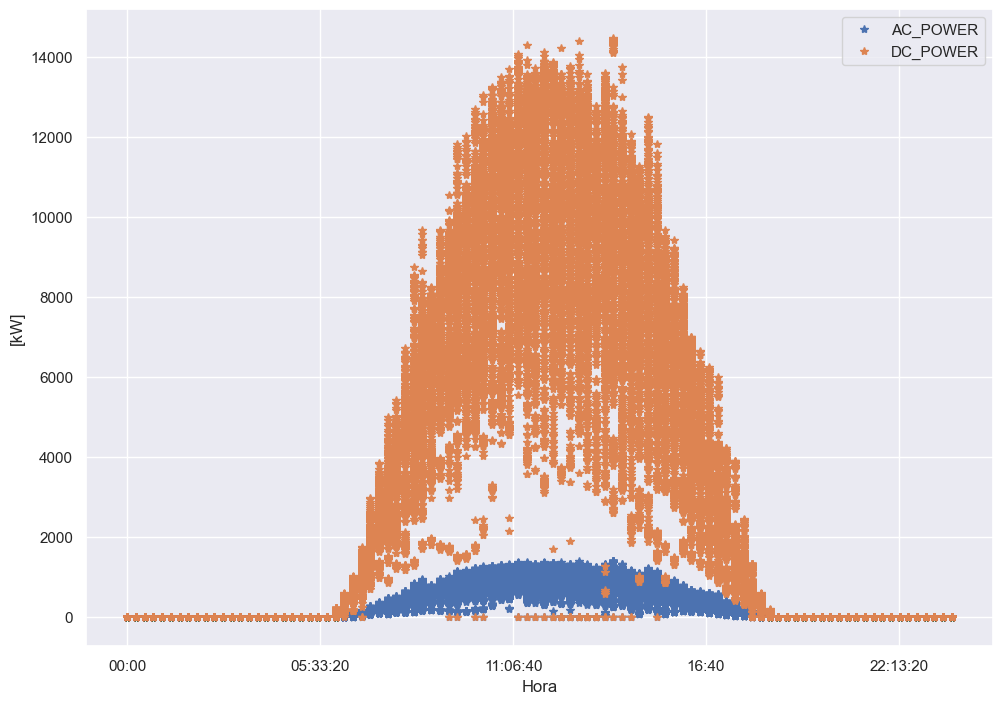

In [7]:
ax = df.set_index('TIME')[['AC_POWER','DC_POWER']].plot(style = '*')
ax.set(xlabel = 'Hora', ylabel='[kW]')

[Text(0.5, 0, 'Fecha'), Text(0, 0.5, '[kW]')]

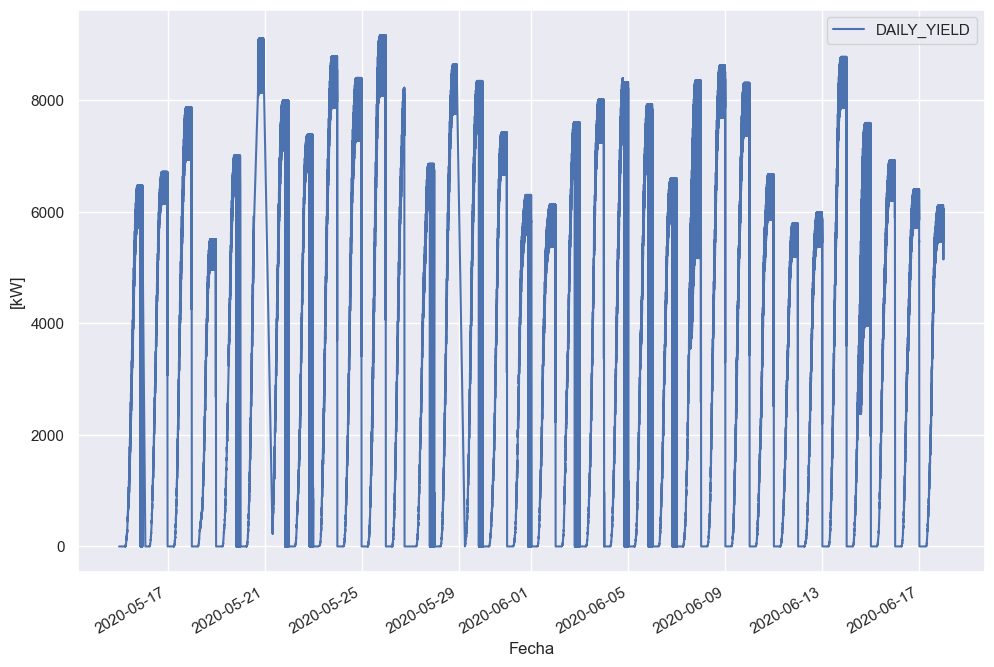

In [8]:
ax = df.set_index('DATE_TIME')[['DAILY_YIELD']].plot()
ax.set(xlabel = 'Fecha', ylabel='[kW]')

[Text(0.5, 0, 'Fecha'), Text(0, 0.5, '[kW]')]

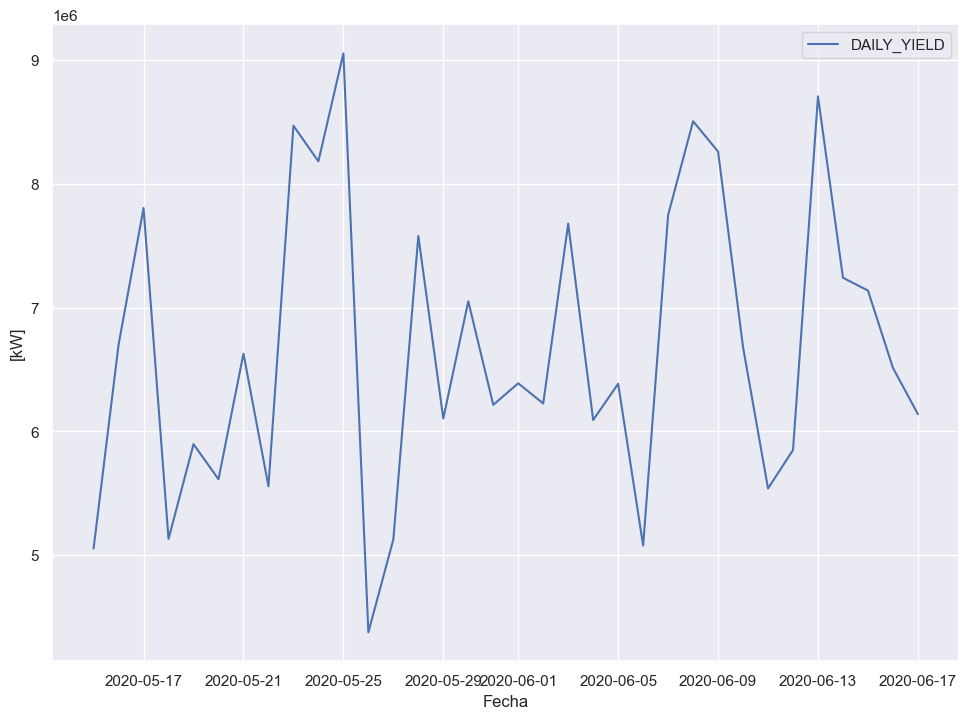

In [9]:
df_diario = df.groupby('DATE').sum()
ax = df_diario[['DAILY_YIELD']].plot()
ax.set(xlabel = 'Fecha', ylabel='[kW]')

[Text(0.5, 0, 'Fecha'), Text(0, 0.5, '[kW]')]

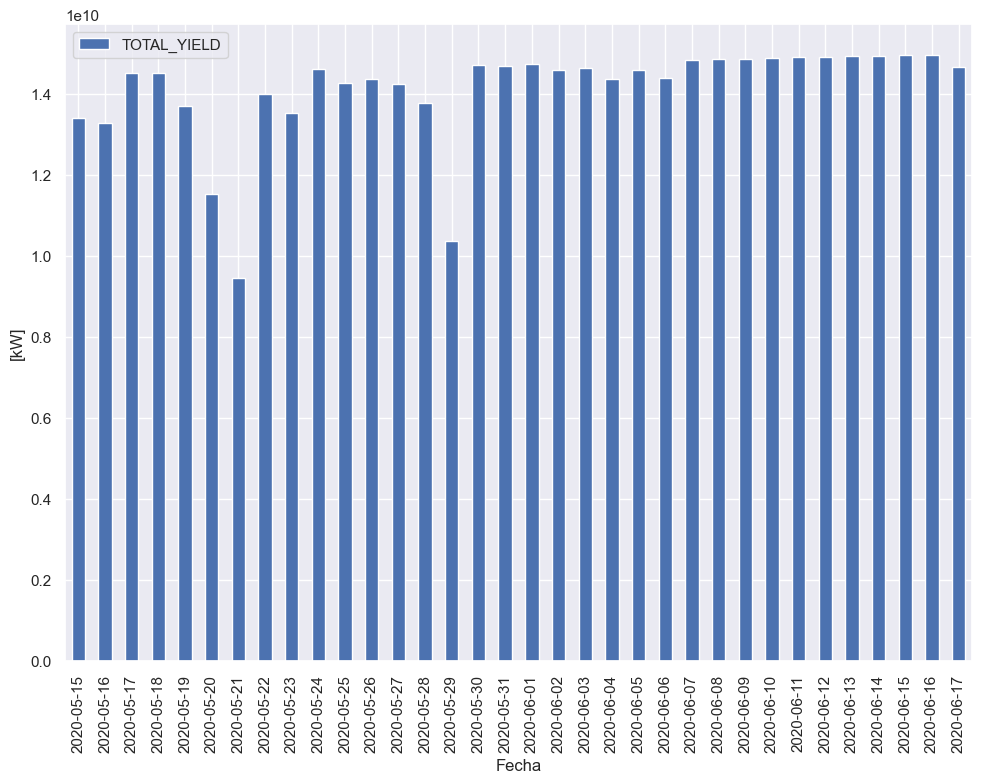

In [10]:
ax = df_diario[['TOTAL_YIELD']].plot(kind = 'bar')
ax.set(xlabel = 'Fecha', ylabel='[kW]')

[Text(0.5, 0, 'Hora'), Text(0, 0.5, '[kW]')]

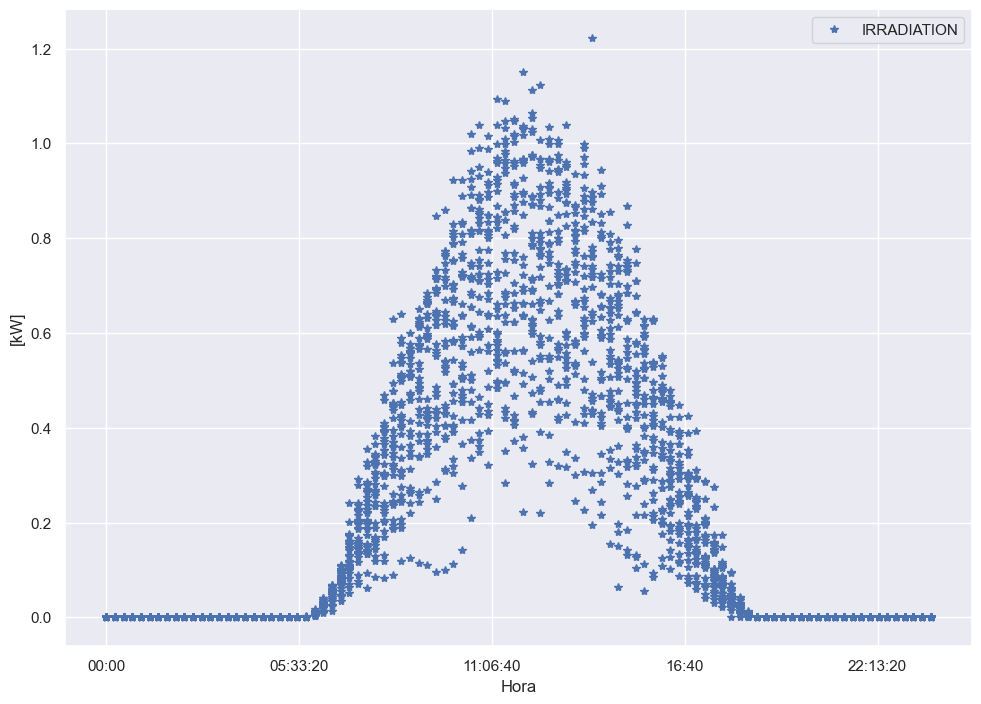

In [11]:
ax = df_w.set_index('TIME')[['IRRADIATION']].plot(style = '*')
ax.set(xlabel = 'Hora', ylabel='[kW]')

[Text(0.5, 0, 'Fecha'), Text(0, 0.5, '[kW]')]

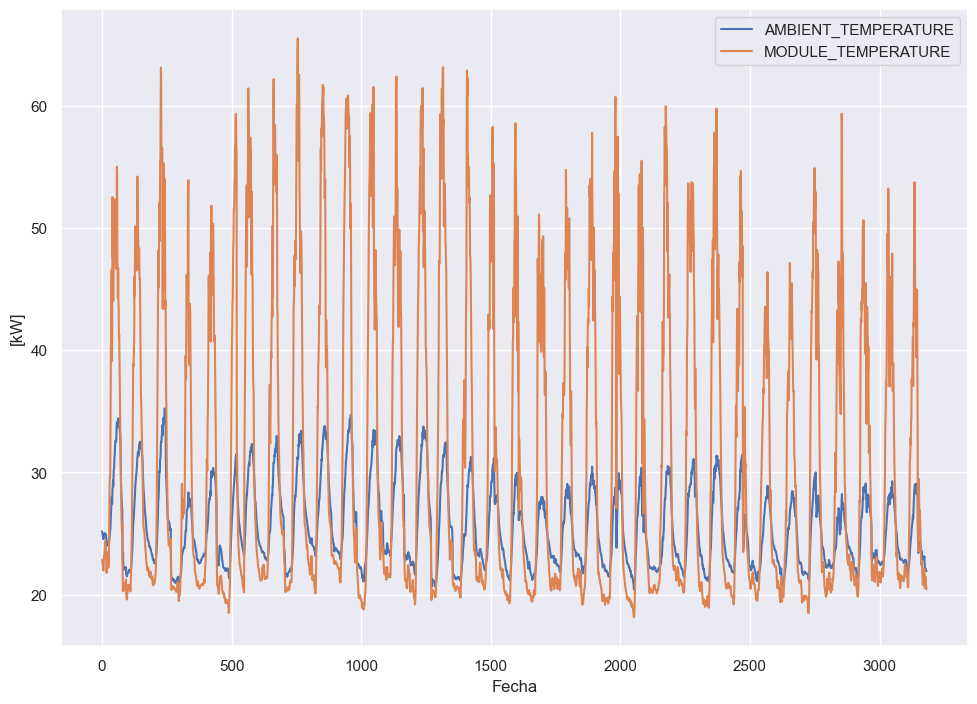

In [12]:
ax = df_w[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']].plot()
ax.set(xlabel = 'Fecha', ylabel='[kW]')

In [13]:
#Cuantos inversores hay?
df.SOURCE_KEY.value_counts()

bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
1IF53ai7Xc0U56Y    3119
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64

In [14]:
#Cuantos inversores hay?
df_w.SOURCE_KEY.value_counts()

HmiyD2TTLFNqkNe    3182
Name: SOURCE_KEY, dtype: int64

In [15]:
df

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME,DATE
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,00:00:00,2020-05-15
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,00:00:00,2020-05-15
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,00:00:00,2020-05-15
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,00:00:00,2020-05-15
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,00:00:00,2020-05-15
...,...,...,...,...,...,...,...,...,...
68773,2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,23:45:00,2020-06-17
68774,2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,23:45:00,2020-06-17
68775,2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,23:45:00,2020-06-17
68776,2020-06-17 23:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,23:45:00,2020-06-17


In [16]:
df = df.drop(columns = ['PLANT_ID', 'TIME', 'DATE'])
df_w = df_w.drop(columns = ['SOURCE_KEY', 'PLANT_ID', 'TIME', 'DATE'])
df = pd.merge(df, df_w, on=['DATE_TIME'])